In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from pysheds.grid import Grid
import timeit

%matplotlib inline

In [2]:
grid = Grid.from_raster("../data/n30w100_dir", data_name="dir", input_type="ascii")

# N    NE    E    SE    S    SW    W    NW
dirmap = (64, 128, 1, 2, 4, 8, 16, 32)

In [3]:
gridsize = grid.dir.size
gridshape = grid.dir.shape
gridbytes = grid.dir.nbytes

print(gridshape[0], " x ", gridshape[1], " grid")
print(gridsize, " gridcells")
print(gridbytes / 1000000, "MB in memory (stored as uint8)")

6000  x  6000  grid
36000000  gridcells
36.0 MB in memory (stored as uint8)


In [4]:
fdir = grid.view("dir")

In [5]:
%timeit grid.accumulation(fdir, dirmap=dirmap, pad_inplace=True, direction_name='dir')

15 s ± 700 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [6]:
pour_y, pour_x = np.unravel_index(np.argmax(grid.acc), gridshape)

In [7]:
%timeit grid.catchment(pour_x, pour_y, dirmap=dirmap, recursionlimit=15000, xytype='index')

4.55 s ± 114 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [8]:
catchment_cells = np.count_nonzero(grid.view("catch"))
print(catchment_cells, " cells in catchment")

9792691  cells in catchment


In [9]:
D = np.logspace(1, 3.7782, 15).astype(int)

In [10]:
times = []

for i in D:
    fdir_sub = fdir[:i, :i]
    start = timeit.default_timer()
    grid.accumulation(fdir_sub, dirmap=dirmap, pad_inplace=True)
    stop = timeit.default_timer()
    dt = stop - start
    times.append(dt)

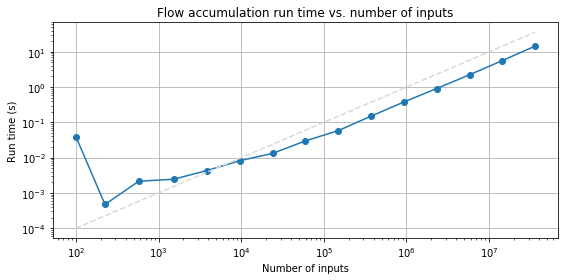

In [11]:
fig, ax = plt.subplots(figsize=(8, 4))

ax.loglog(D**2, times, marker="o")
ax.loglog(D**2, D**2 / 1e6, linestyle="--", c="0.85")
ax.set_xlabel("Number of inputs")
ax.set_ylabel("Run time (s)")
ax.set_title("Flow accumulation run time vs. number of inputs")
ax.grid()
plt.tight_layout()
plt.savefig("accumulation_runtime.pdf")

In [12]:
grid.accumulation(fdir, dirmap=dirmap, pad_inplace=False)
pour_y, pour_x = np.unravel_index(np.argmax(grid.acc), gridshape)
grid.catchment(
    pour_x,
    pour_y,
    dirmap=dirmap,
    direction_name="dir",
    recursionlimit=15000,
    xytype="index",
)
grid.accumulation(direction_name="catch", dirmap=dirmap, pad_inplace=False)

In [13]:
D = np.logspace(2, np.log10(grid.acc.max()), 20).astype(int)

In [14]:
ix = [np.argmin(np.abs(grid.acc.ravel() - i)) for i in D]

In [15]:
times = []
sizes = []

for i in ix:
    pour_y, pour_x = np.unravel_index(i, fdir.shape)
    fdir_sub = fdir[:i, :i]
    start = timeit.default_timer()
    grid.catchment(pour_x, pour_y, fdir, dirmap=dirmap, recursionlimit=15000, xytype="index")
    stop = timeit.default_timer()
    dt = stop - start
    size = np.count_nonzero(grid.catch)
    times.append(dt)
    sizes.append(size)

In [16]:
times = np.asarray(times)
sizes = np.asarray(sizes)

In [17]:
s = pd.Series(times, index=sizes).sort_index()

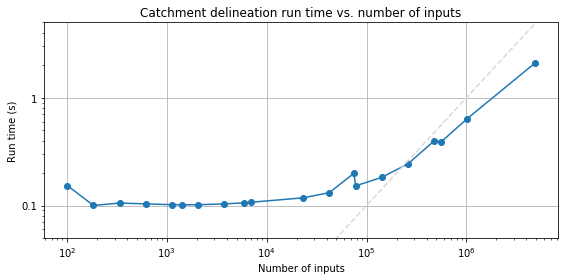

In [18]:
fig, ax = plt.subplots(figsize=(8, 4))

ax.loglog(s.index, s.values, marker="o")
ax.loglog(s.index[9:], s.index[9:] / 1e6, linestyle="--", c="0.85")
ax.set_xlabel("Number of inputs")
ax.set_ylabel("Run time (s)")
ax.set_title("Catchment delineation run time vs. number of inputs")
ax.set_ylim(0.05, 5)
ax.yaxis.set_ticklabels(["", "", "0.1", "1"])
ax.grid()
plt.tight_layout()
plt.savefig("catchment_runtime.pdf")

In [19]:
grid.accumulation(fdir, dirmap=dirmap, pad_inplace=False, direction_name="dir")

In [20]:
pour_y, pour_x = np.unravel_index(np.argmax(grid.acc), gridshape)

In [21]:
grid.catchment(pour_x, pour_y, dirmap=dirmap, recursionlimit=15000, xytype="index")

In [22]:
np.count_nonzero(grid.catch)

9792691